In [ ]:
import numpy as np
from PIL import Image
import requests
from transformers import AutoProcessor, AutoModel
import pandas as pd
import os
import glob
import torch
import re
from pathlib import Path
from torchvision.transforms.functional import resize as torch_resize
import torchvision.transforms.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision.transforms.functional import resize as torch_resize
from torchvision.transforms.functional import to_tensor, to_pil_image




2025-07-21 23:14:56.111181: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-21 23:14:56.192845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753132496.224564  775257 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753132496.236274  775257 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753132496.282952  775257 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:


# @title ## Authenticate with HuggingFace, skip if you have a HF_TOKEN secret

# Authenticate user for HuggingFace if needed. Enter token below if requested.
from huggingface_hub.utils import HfFolder

if HfFolder.get_token() is None:
    from huggingface_hub import notebook_login
    notebook_login()
     


## when use the text endoer, good to check if the token size is over the limit of size and the way to shorten it.
t


In [ ]:

INPUT_DIMENSION = [448, 448]

def resize(image):
    """
    Resize a PIL.Image using torchvision's resize (bilinear).
    """
    image_tensor = to_tensor(image)  # Convert PIL.Image to torch.Tensor (C, H, W), float32
    resized_tensor = torch_resize(image_tensor, size=INPUT_DIMENSION, interpolation=3)  # 3 = bilinear
    return to_pil_image(resized_tensor)  # Convert back to PIL.Image



In [15]:
txt_file='/home/mding3/local_scratch/fl_summer/files/p10/p10000764/s57375967.txt'
#read this file into in 
def extract_findings_and_impression(text: str) -> str:
    """
    Extract and concatenate the 'Findings' and 'Impression' sections from a radiology report.

    Sections are located by their headings (case-insensitive), and all text between each heading
    and the next ALL-CAPS heading (or end-of-text) is captured.
    """
    combined = []
    for section in ("FINDINGS", "IMPRESSION"):
        # Regex: match 'SECTION:' then lazily up to next all-caps heading ending with ':' or end of text
        pattern = rf"(?is){section}:(.*?)(?=\n[A-Z ]+?:|\Z)"
        match = re.search(pattern, text)
        if match:
            combined.append(match.group(1).strip())
    if len(combined) > 0:
      
        return " ".join(combined)
    if len(combined) == 0:
        return text.strip()


def split_and_filter_sentences(text: str, min_words: int = 3) -> list[str]:
    """
    Split text into sentences on ., !, or ? and remove any sentence with fewer than min_words words.
    """
    # Split on punctuation followed by whitespace
    sentences = re.split(r"(?<=[\.!?])\s+", text)
    # Filter out short sentences
    return [s.strip() for s in sentences if len(s.split()) >= min_words]


In [13]:
report_path = Path(txt_file)

# 2) Read the report text
report_text = report_path.read_text(encoding="utf-8")

# 3) Extract and combine Findings & Impression
combined_text = extract_findings_and_impression(report_text)

# 4) Split into sentences and filter
sentences = split_and_filter_sentences(combined_text, min_words=3)
sentences_whole="".join(sentences)
sentences_whole

'PA and lateral views of the chest provided.The lungs are adequately\n aerated.There is a focal consolidation at the left lung base adjacent to the lateral\n hemidiaphragm.There is mild vascular engorgement.There is bilateral apical\n pleural thickening.The cardiomediastinal silhouette is remarkable for aortic arch calcifications.The heart is top normal in size.Focal consolidation at the left lung base, possibly representing aspiration or\n pneumonia.Central vascular engorgement.'

In [ ]:
import pandas as pd
import os
import glob
front_file='/home/mding3/local_scratch/fl_summer/summary/front_postero_anterior_view_only.csv'
df_front = pd.read_csv(front_file)
for i, row in df_front.iterrows():
    study_id = row['study_id']
    subject_id = row['subject_id']
    df_front.at[i, 'filename'] = str(int(subject_id)) +'_'+str(int(study_id)) 
df_front.head()

front_view_id= df_front['filename'].tolist()
front_view_id

In [ ]:

torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


model = AutoModel.from_pretrained("google/medsiglip-448").to(device)
processor = AutoProcessor.from_pretrained("google/medsiglip-448")



model.to(device)
model.eval()

img_dir='/home/mding3/local_scratch/fl_summer/embeddings/image/img'

images=glob.glob(img_dir + '/*.jpg')

text_dir='/home/mding3/local_scratch/fl_summer/embeddings/bart_summary_txt'

i=0
for image_path in images:
    print(i)
    i+=1
    base_name = image_path.split('/')[-1].split('.jpg')[0]
    text_path= os.path.join(text_dir, f"{base_name}.txt")  
    report_path = Path(text_path)

    # 2) Read the report text
    report_text = report_path.read_text(encoding="utf-8")

    # 3) Extract and combine Findings & Impression
    combined_text = extract_findings_and_impression(report_text)

    # 4) Split into sentences and filter
    sentences = split_and_filter_sentences(combined_text, min_words=3)
    text= " ".join(sentences)


    

    texts=[text]
    one_img=[image_path]

    img=[Image.open(image_path).convert("RGB")]
    img=resize(img[0])
    resized_imgs = [img]


    with torch.no_grad():
        inputs = processor(text=texts, images=resized_imgs,truncation=True,    padding="max_length", return_tensors="pt").to(device)

        outputs = model(**inputs)
        


        text_features = outputs.text_embeds
        image_features = outputs.image_embeds

        #text_features=text_features/ text_features.norm(dim=-1, keepdim=True)
        #image_features=image_features/ image_features.norm(dim=-1, keepdim=True)

        image_features = image_features.cpu().numpy()
        text_features = text_features.cpu().numpy()


        combined_features = np.concatenate([image_features, text_features], axis=1)
    #savfe the combined_features to a file
        output_dir='/home/mding3/local_scratch/fl_summer/embeddings/img_text_embedding/medsiglip_448'
        os.makedirs(output_dir, exist_ok=True)
        output_file = os.path.join(output_dir, f"{base_name}.npy")
        np.save(output_file, combined_features)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## classifiaction

In [18]:
df_test.shape

(2000, 1027)

In [1]:
import os
import numpy as np
import torch
import pandas as pd

# Configuration
exp_name='medsiglip_448'
emb_dir = f"/home/mding3/local_scratch/fl_summer/embeddings/img_text_embedding/{exp_name}"

embeddings = []
labels = []



import pandas as pd
df_file='/home/mding3/local_scratch/fl_summer/embeddings/Fusioned_emb-20250716T130653Z-1-001/Fusioned_emb/fused_clip_embeddings.csv'
df= pd.read_csv(df_file)  # Assuming the first column is an index
df['filename']= df['filename'].apply(lambda x: x.split('.jpg')[0])  # Extract filename from path
df.head()
#drop the 514th column
df = df.drop(columns=['clip_textimg_512'], errors='ignore')
df.head()
#make a arry based on the df, the label column is name label, and from 3rd colun to last aare differnt X
X = df.iloc[:, 2:].values  # Extract features
y = df['label'].values  # Extract labels
X.shape, y.shape
#
train_df='/home/mding3/local_scratch/fl_summer/summary/train_df.csv'
train_df = pd.read_csv(train_df)  # Assuming the first column is an index
for i, row in train_df.iterrows():
    study_id = row['study_id']
    subject_id = row['subject_id']
    train_df.at[i, 'filename'] = str(int(subject_id)) +'_'+str(int(study_id)) 
train_df.head()
df_all_train = pd.merge(df, train_df, on='filename', how='inner')
#remove the columns 'subject_id', 'study_id', 'Lung Opacity'
df_all_train = df_all_train.drop(columns=['subject_id', 'study_id', 'Lung Opacity'], errors='ignore')
df_all_train.head()

#mkae the rest as X_test and use the same y
df_test = df[~df['filename'].isin(train_df['filename'])]

def keep_front_view_only(df_input):

    front_file='/home/mding3/local_scratch/fl_summer/summary/front_postero_anterior_view_only.csv'
    df_front = pd.read_csv(front_file)
    for i, row in df_front.iterrows():
        study_id = row['study_id']
        subject_id = row['subject_id']
        df_front.at[i, 'filename'] = str(int(subject_id)) +'_'+str(int(study_id)) 
    df_front.head()

    front_view_id= df_front['filename'].tolist()
   
    df_input = df_input[~df_input['filename'].isin(front_view_id)]
    return df_input


df_all_train = keep_front_view_only(df_all_train)
df_test = keep_front_view_only(df_test)
train_df = keep_front_view_only(train_df)


In [23]:

embeddings = []
labels = []
for _, row in train_df.iterrows():
    study_id   = int(row['study_id'])
    subject_id = int(row['subject_id'])
    base_name  = f"{subject_id}_{study_id}"
    
    # Collect the label
    labels.append(row['Lung Opacity'])
    
    # Build the .pt filepath
    file_path = os.path.join(emb_dir, f"{base_name}.npy")
    if not os.path.exists(file_path):
        print(f"Warning: file not found: {file_path}")
        continue
    
    # Load the embedding
    embed = np.load(file_path, allow_pickle=True)
    embeddings.append(embed)
 

# Stack into a (n_samples, dim) array and build label array
X_train = np.vstack(embeddings)  # shape: (n_samples, embedding_dim)
y_train = np.array(labels)       # shape: (n_samples,)

print(f"Loaded {X_train.shape[0]} samples, each of dimension {X_train.shape[1]}")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)



embeddings = []
labels = []
for i, row in df_test.iterrows():
    filename = row['filename']
    filename = filename.split('.jpg')[0]  # Remove the .npy extension if present
    base_name  =filename
    
    # Collect the label
    labels.append(row['label'])
    # Build the .pt filepath
    file_path = os.path.join(emb_dir, f"{base_name}.npy")
    embed= np.load(file_path, allow_pickle=True)
    if not os.path.exists(file_path):
        print(f"Warning: file not found: {file_path}")
        continue
    
    # Load the embedding
    embeddings.append(embed)
# Stack into a (n_samples, dim) array and build label array
X_test = np.vstack(embeddings)  # shape: (n_samples, embedding_dim)
y_test = np.array(labels)       # shape: (n_samples,)

print(f"Loaded {X_test.shape[0]} samples, each of dimension {X_test.shape[1]}")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Loaded 957 samples, each of dimension 2304
X_train shape: (957, 2304)
y_train shape: (957,)
Loaded 412 samples, each of dimension 2304
X_test shape: (412, 2304)
y_test shape: (412,)


In [3]:
y_train.shape

(957,)

In [3]:
def logistic_regression_pipeline(X_train, y_train, X_test, y_test):

    from sklearn.preprocessing import MinMaxScaler, StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, roc_auc_score
    from sklearn.pipeline import Pipeline

    # Assume X_train, y_train, X_test, y_test are NumPy arrays already defined

    # 1) Build a preprocessing + classification pipeline
    # 1) Build a preprocessing + classification pipeline
    pipeline = Pipeline([


        ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
    ])

    # 2) Train on the training set
    pipeline.fit(X_train, y_train)

    # 3) Make predictions on the test set
    y_pred  = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]  # probability of the positive class

    # 4) Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc      = roc_auc_score(y_test, y_proba)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test ROC AUC : {auc:.4f}")

In [18]:

logistic_regression_pipeline(X_train[:,1152:], y_train, X_test[:,1152:], y_test)

Test Accuracy: 0.7330
Test ROC AUC : 0.8020


In [12]:
X_train_first=X_train.copy()
X_train_first[:,:1152]=0
X_test_first=X_test.copy()
X_test_first[:,:1152]=0

logistic_regression_pipeline(X_train_first, y_train, X_test_first, y_test)

Test Accuracy: 0.7184
Test ROC AUC : 0.7890


In [11]:
X_train_first=X_train.copy()
X_train_first[:,1152:]=0
X_test_first=X_test.copy()
X_test_first[:,1152:]=0

logistic_regression_pipeline(X_train_first, y_train, X_test_first, y_test)

Test Accuracy: 0.7039
Test ROC AUC : 0.7937


In [4]:
logistic_regression_pipeline(X_train, y_train, X_test, y_test)

Test Accuracy: 0.7403
Test ROC AUC : 0.8298


In [24]:
# 1) Min–Max normalize to [0, 1] using training‐set stats
X_min = X_train.min(axis=0)
X_max = X_train.max(axis=0)
# avoid division by zero
scale = (X_max - X_min)
scale[scale == 0] = 1.0

X_train_norm = (X_train - X_min) / scale
X_test_norm  = (X_test  - X_min) / scale

# 2) Standardize to zero mean, unit variance using training‐set stats
mean = X_train_norm.mean(axis=0)
std  = X_train_norm.std(axis=0)
std[std == 0] = 1.0

X_train = (X_train_norm - mean) / std
X_test = (X_test_norm  - mean) / std


In [30]:




import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score

import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

# Assume you already have:
# X_train: np.ndarray of shape (N, 1024)
# y_train: np.ndarray of shape (N,)
# And you’ve done:
X_tensor = torch.from_numpy(X_train).float()
y_tensor = torch.from_numpy(y_train).float()

# 1) Wrap in a TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)

# 2) Compute split sizes
val_ratio = 0.3
n_total = len(dataset)
n_val   = int(val_ratio * n_total)
n_train = n_total - n_val

# 3) Do the (deterministic) split
train_ds, val_ds = random_split(
    dataset,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(42)
)

# 4) Build DataLoaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)

print(f"Train samples: {len(train_ds)}  |  Val samples: {len(val_ds)}")

X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=32, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)


# Model, loss, optimizer
class Net(nn.Module):
    def __init__(self):
        super().__init__()
       
        self.fc1 = nn.Linear(2304, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 1)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x= F.relu(self.fc3(x))
       
        return self.fc4(x).squeeze(1)

device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = Net().to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)


# —— Training with validation accuracy tracking ——
num_epochs = 20

# Lists for collecting metrics
metrics = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_acc": []
}

for epoch in range(1, num_epochs + 1):
    # --- Train phase ---
    model.train()
    total_train_loss = 0.0
    for xb, yb in train_loader:
        #xb[:,512:] = 0  # Zero out the second half of the input


        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * xb.size(0)
    avg_train_loss = total_train_loss / n_train

    # --- Validation phase ---
    model.eval()
    total_val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for xb, yb in val_loader:
          
            xb, yb = xb.to(device), yb.to(device)
            #xb[:, :512] = 0
            logits = model(xb)
            total_val_loss += criterion(logits, yb).item() * xb.size(0)
            preds = (torch.sigmoid(logits) >= 0.5).float()
            correct += (preds == yb).sum().item()

    avg_val_loss = total_val_loss / n_val
    val_acc      = correct / n_val

    # --- Log metrics ---
    metrics["epoch"].append(epoch)
    metrics["train_loss"].append(avg_train_loss)
    metrics["val_loss"].append(avg_val_loss)
    metrics["val_acc"].append(val_acc)

    print(
        f"Epoch {epoch:02d}/{num_epochs} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

# —— After training, build a DataFrame for easy plotting/analysis ——
df_metrics = pd.DataFrame(metrics)

# You can now do things like:





Train samples: 670  |  Val samples: 287
Epoch 01/20 | Train Loss: 0.8796 | Val Loss: 0.5174 | Val Acc: 0.7735
Epoch 02/20 | Train Loss: 0.7214 | Val Loss: 0.4507 | Val Acc: 0.7979
Epoch 03/20 | Train Loss: 0.6341 | Val Loss: 0.3883 | Val Acc: 0.8397
Epoch 04/20 | Train Loss: 0.5515 | Val Loss: 0.3326 | Val Acc: 0.8502
Epoch 05/20 | Train Loss: 0.4712 | Val Loss: 0.2603 | Val Acc: 0.9024
Epoch 06/20 | Train Loss: 0.3717 | Val Loss: 0.1846 | Val Acc: 0.9443
Epoch 07/20 | Train Loss: 0.2641 | Val Loss: 0.1126 | Val Acc: 0.9895
Epoch 08/20 | Train Loss: 0.1651 | Val Loss: 0.0722 | Val Acc: 0.9861
Epoch 09/20 | Train Loss: 0.1046 | Val Loss: 0.0378 | Val Acc: 0.9965
Epoch 10/20 | Train Loss: 0.0591 | Val Loss: 0.0202 | Val Acc: 1.0000
Epoch 11/20 | Train Loss: 0.0290 | Val Loss: 0.0113 | Val Acc: 1.0000
Epoch 12/20 | Train Loss: 0.0181 | Val Loss: 0.0073 | Val Acc: 1.0000
Epoch 13/20 | Train Loss: 0.0099 | Val Loss: 0.0047 | Val Acc: 1.0000
Epoch 14/20 | Train Loss: 0.0068 | Val Loss: 0.003

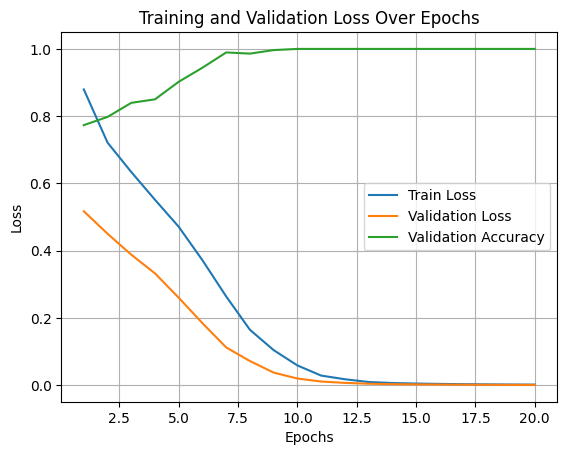

Test Accuracy: 0.7791
Test ROC AUC : 0.8397


In [31]:
#plotting the training loss
import matplotlib.pyplot as plt

#plot both train and validation losses  and val_acc from df_metrics
plt.plot(df_metrics['epoch'], df_metrics['train_loss'], label='Train Loss')
plt.plot(df_metrics['epoch'], df_metrics['val_loss'], label='Validation Loss')
plt.plot(df_metrics['epoch'], df_metrics['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Evaluation on test set
model.eval()
y_true = []
y_scores = []
with torch.no_grad():
    for xb, yb in test_loader:
        #xb[:, 512:] = 0
        #xb1=xb[:,:512]
        #xb2=xb[:,512:]
        #element-wise multiplication

        xb = xb.to(device)

        logits = model(xb)
        probs = torch.sigmoid(logits)
        y_true.extend(yb.numpy())
        y_scores.extend(probs.cpu().numpy())

# Convert probabilities to binary predictions
y_pred = [1 if p >= 0.5 else 0 for p in y_scores]

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_scores)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC AUC : {auc:.4f}")